In [1]:
import numpy as np
#import scipy
#import scipy.io
import scipy.signal
import matplotlib.pyplot as plt
import csd_helper
import pdb

# Simulate 180s sine wave at 4 Hz - add incoherent wave

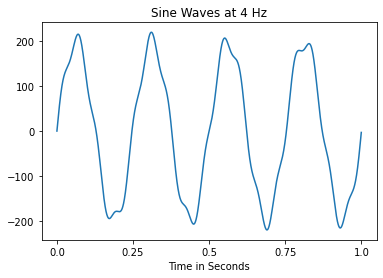

In [118]:
srate = 2400
time = np.arange(181 * srate)

freq = 4 # Hz

amplitude = 200

sine4 = np.sin(2 * np.pi * 4 * time / srate) * amplitude

sine17 = np.sin(2 * np.pi * 17 * time / srate) * amplitude

sine13 = np.sin(2 * np.pi * 17 * time / srate) * amplitude

sine = sine4 + 0.1 * sine17

ticks = np.arange(0, srate+1, 600)
labels = [np.round(t, 2) for t in (ticks/srate)]

plt.plot(sine[:srate])
plt.xticks(ticks, labels)
plt.xlabel("Time in Seconds")
plt.title(f"Sine Waves at {freq} Hz")
plt.show()

### Create Noise - comparable to real data

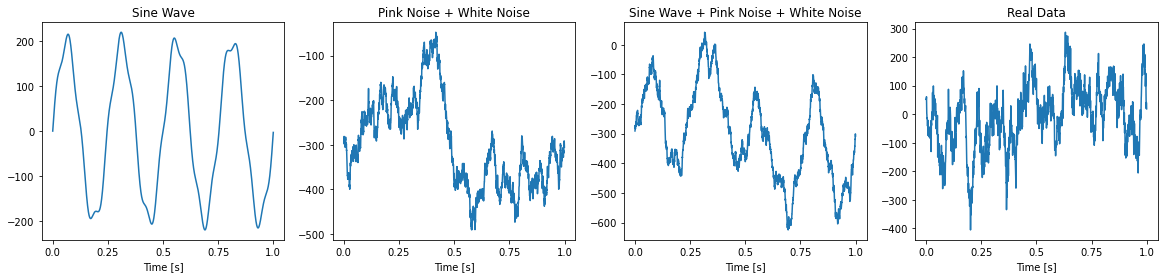

In [119]:
on_data = np.load("subj1_on_R7_raw.npy")[:2]
off_data = np.load("subj1_off_R7_raw.npy")[:2]

size = time.size

#np.random.seed(1)

def noise_white(size):
    noise = np.random.normal(0, 1, size=size)
    return noise

def noise_pink(size):
    white_noise = noise_white(size=size)
    # Get fourier spectrum
    freqs = np.fft.rfftfreq(size, d=1/srate)
    amp_white = np.fft.rfft(white_noise)
    # Get Multiply Amp Spectrum by 1/f (avoid divison by 0)
    amp_pink = amp_white / np.r_[1, freqs[1:]]
    # Transform back to get pink noise time series
    pink_noise = np.fft.irfft(amp_pink)
    return pink_noise

def noise_wp(size, pink_scale=3000, white_scale=2):
    return noise_pink(size) * pink_scale + noise_white(size) * white_scale

noise = noise_wp(size, 3000, 2)

signal_noise = sine + noise

fig, ax = plt.subplots(1, 4, figsize=[20, 4], sharey=False)

ax[0].plot(sine[:srate])
ax[0].set_xticks(ticks)
ax[0].set_xticklabels(labels)
ax[0].set_xlabel("Time [s]")
ax[0].set_title("Sine Wave")

ax[1].plot(noise[:srate])
ax[1].set_xticks(ticks)
ax[1].set_xticklabels(labels)
ax[1].set_xlabel("Time [s]")
ax[1].set_title("Pink Noise + White Noise")

ax[2].plot(signal_noise[:srate])
ax[2].set_xticks(ticks)
ax[2].set_xticklabels(labels)
ax[2].set_xlabel("Time [s]")
ax[2].set_title("Sine Wave + Pink Noise + White Noise")

ax[3].plot(on_data[0, srate:2*srate])
ax[3].set_xticks(ticks)
ax[3].set_xticklabels(labels)
ax[3].set_xlabel("Time [s]")
ax[3].set_title("Real Data");

## Create coherent on-signal and incoherent noisy off signal

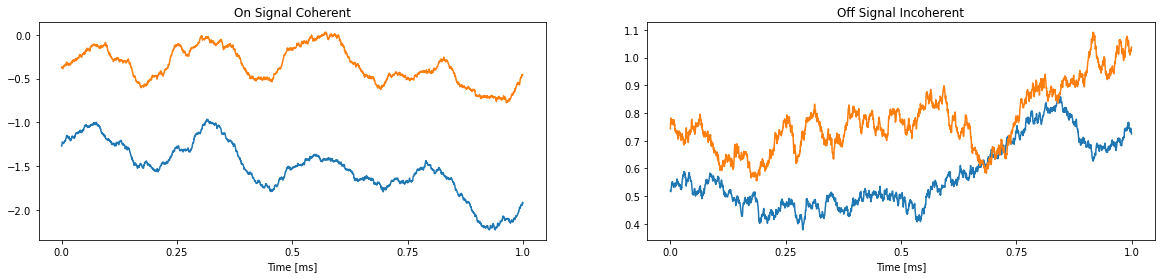

In [120]:
on1_noise = sine + noise_wp(size, 3000, 2)
on2_noise = sine + noise_wp(size, 3000, 2)

off1_noise = sine + noise_wp(size, 3000, 2) * 100 # extra noise
off2_noise = sine + noise_wp(size, 3000, 2) * 100 # extra noise

on1_noise = (on1_noise - on1_noise.mean() ) / np.std(on1_noise)
on2_noise = (on2_noise - on2_noise.mean() ) / np.std(on2_noise)

off1_noise = (off1_noise - off1_noise.mean() ) / np.std(off1_noise)
off2_noise = (off2_noise - off2_noise.mean() ) / np.std(off2_noise)


on_signal = np.array([on1_noise, on2_noise])
off_signal = np.array([off1_noise, off2_noise])



fig, ax = plt.subplots(1, 2, figsize=[20, 4], sharey=False)

ax[0].plot(on_signal[0, :srate])
ax[0].plot(on_signal[1, :srate])
ax[0].set_xticks(ticks)
ax[0].set_xticklabels(labels)
ax[0].set_xlabel("Time [ms]")
ax[0].set_title("On Signal Coherent")

ax[1].plot(off_signal[0, :srate])
ax[1].plot(off_signal[1, :srate])
ax[1].set_xticks(ticks)
ax[1].set_xticklabels(labels)
ax[1].set_xlabel("Time [ms]")
ax[1].set_title("Off Signal Incoherent");

In [121]:
on_signal.mean(1)

array([ 1.01020072e-16, -6.00624522e-17])

## Calculate spectrum

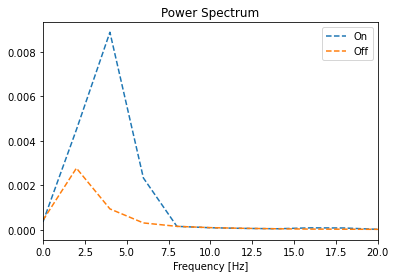

In [122]:
on_f, on_csd  = csd_helper.calc_csd(on_signal, fs=srate, nperseg=int(0.5*srate), axis=-1)
off_f, off_csd = csd_helper.calc_csd(off_signal, fs=srate, nperseg=int(0.5*srate), axis=-1)

plt.plot(on_f, np.abs(on_csd[1, 1]), "--", label="On")
plt.plot(on_f, np.abs(off_csd[1, 1]), "--", label="Off")
plt.legend()
plt.xlim([0, 20])
plt.title("Power Spectrum")
plt.xlabel("Frequency [Hz]")
plt.show()

### Calculate Coherence

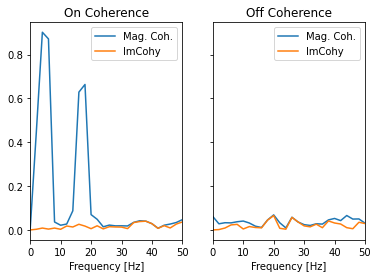

In [123]:
on_coherence = csd_helper.calc_coherence(on_csd)
off_coherence = csd_helper.calc_coherence(off_csd)

fig, ax = plt.subplots(1, 2, sharey=True)
ax[0].plot(on_f, np.abs(on_coherence[0, 1]), label="Mag. Coh.")
ax[0].plot(on_f, np.abs(on_coherence[0, 1].imag), label="ImCohy")
ax[0].set_xlim([0, 50])
ax[0].legend()
ax[0].set_title("On Coherence")
ax[0].set_xlabel("Frequency [Hz]")
ax[1].plot(on_f, np.abs(off_coherence[0, 1]), label="Mag. Coh.")
ax[1].plot(on_f, np.abs(off_coherence[0, 1].imag), label="ImCohy")
ax[1].set_xlim([0, 50])
ax[1].legend()
ax[1].set_title("Off Coherence")
ax[1].set_xlabel("Frequency [Hz]")
plt.show()

## Calculate Statistics between duplicated on- and off-condition

In [124]:
N_bootstrap = 500
# calculate a bootstrap for the coherence between on and of
# the coherence is only calculated using the mean across segments
# for the bootstrap, segments are randomly resampled from on and off condition
# with replacement
f_stat, mag_stat, imag_stat = csd_helper.bootstrap_coherence_diff(on_signal, off_signal, fs=srate, nperseg=int(1 * srate), axis=-1, N_bootstrap=N_bootstrap, frange = (1,45))

######################
# Calculate p values #
######################
#test only one triangle of the data (symmetric axis and not diagonal)
ix, iy = np.tril_indices(mag_stat[0].shape[0], -1)
mag_p = np.ones_like(mag_stat[0])
imag_p = np.ones_like(mag_stat[0])

# for calculating the p values take the absolute values for a two-tailed test
mag_p[ix, iy] = csd_helper.stepdown_p(np.ravel(np.abs(mag_stat[0][ix, iy])), np.abs(mag_stat[1][:,ix,iy]).reshape((N_bootstrap, -1), order='C')).reshape((len(ix), -1), order='C')
# make the array symmetric again
mag_p = mag_p + np.transpose(mag_p, (1,0,2)) - 1

imag_p[ix, iy] = csd_helper.stepdown_p(np.ravel(np.abs(imag_stat[0][ix, iy])), np.abs(imag_stat[1][:,ix,iy]).reshape((N_bootstrap, -1), order='C')).reshape((len(ix), -1), order='C')
# make the array symmetric again
imag_p = imag_p + np.transpose(imag_p, (1,0,2)) - 1

/Users/moritzgerster/Documents/Code/Litvak11/code/csd_helper.py:175: RuntimeWarning: divide by zero encountered in arctanh
  x_mag = np.arctanh(x_mag)
/Users/moritzgerster/Documents/Code/Litvak11/code/csd_helper.py:176: RuntimeWarning: divide by zero encountered in arctanh
  y_mag = np.arctanh(y_mag)
/Users/moritzgerster/Documents/Code/Litvak11/code/csd_helper.py:179: RuntimeWarning: invalid value encountered in subtract
  (x_mag - x_mag_mean[...,np.newaxis])**2, -1)
/Users/moritzgerster/Documents/Code/Litvak11/code/csd_helper.py:182: RuntimeWarning: invalid value encountered in subtract
  (y_mag - y_mag_mean[...,np.newaxis])**2, -1)
/Users/moritzgerster/Documents/Code/Litvak11/code/csd_helper.py:184: RuntimeWarning: invalid value encountered in subtract
  t_mag = ((x_mag_mean - y_mag_mean) /
/Users/moritzgerster/Documents/Code/Litvak11/code/csd_helper.py:200: RuntimeWarning: invalid value encountered in true_divide
  t_imag = ((x_imag_mean - y_imag_mean) /
100%|██████████| 45/45 [00:0

In [125]:
f_stat[16]

17.0

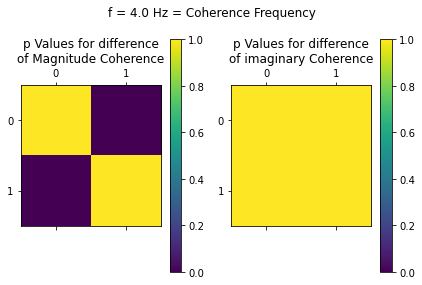

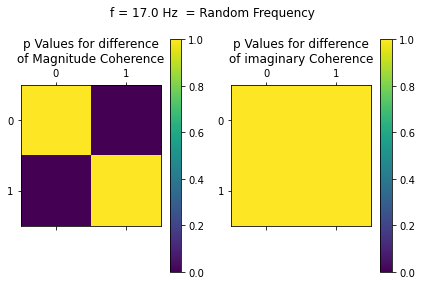

In [127]:
freq_idx = 3

fig, ax = plt.subplots(ncols=2, nrows=1)
cb0 = ax[0].matshow(mag_p[...,freq_idx], vmin=0, vmax=1)
cb1 = ax[1].matshow(imag_p[...,freq_idx], vmin=0, vmax=1)
ax[0].set_title('p Values for difference\nof Magnitude Coherence')
ax[1].set_title('p Values for difference\nof imaginary Coherence')
fig.colorbar(cb0, ax=ax[0])
fig.colorbar(cb1, ax=ax[1])
#ax[0].set_yticklabels(["SMA"])
fig.suptitle('f = {} Hz = Coherence Frequency'.format(f_stat[freq_idx]))
plt.tight_layout()
#fig.savefig('p_values_20Hz.png')

freq_idx = 16

fig, ax = plt.subplots(ncols=2, nrows=1)
cb0 = ax[0].matshow(mag_p[...,freq_idx], vmin=0, vmax=1)
cb1 = ax[1].matshow(imag_p[...,freq_idx], vmin=0, vmax=1)
ax[0].set_title('p Values for difference\nof Magnitude Coherence')
ax[1].set_title('p Values for difference\nof imaginary Coherence')
fig.colorbar(cb0, ax=ax[0])
fig.colorbar(cb1, ax=ax[1])
#ax[0].set_yticklabels(["SMA"])
fig.suptitle('f = {} Hz  = Random Frequency'.format(f_stat[freq_idx]))
plt.tight_layout()
#fig.savefig('p_values_20Hz.png')

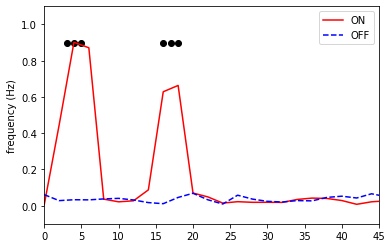

In [128]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(on_f, np.abs(on_coherence[0,1]), 'r-', label='ON')
ax.plot(off_f, np.abs(off_coherence[0,1]), 'b--', label='OFF')
ax.scatter(f_stat[mag_p[0,1]<0.05], 0.9*np.ones(np.sum(mag_p[0,1]<0.05)),
    edgecolors='k', facecolors='k')
ax.set_ylim([-.1, 1.1])
ax.set_xlim([0,45])
#ax.set_title(r'magnitude coherence channel {0} vs. {1}'.format(
 #   ch_names[0], ch_names[5]))
ax.set_ylabel('frequency (Hz)')
ax.legend()
plt.show()


In [107]:
mag_p[0,1]

array([1.        , 1.        , 0.00199601, 0.00199601, 0.00199601,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       0.00199601, 0.00199601, 0.00199601, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 0.99800399, 0.9740519 ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       0.99800399, 1.        , 1.        , 0.99800399, 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ])

# Repeat with lower noise levels

In [133]:
def test_stats(noise_level):
    on1_noise = sine + noise_wp(size, 3000, 2)
    on2_noise = sine + noise_wp(size, 3000, 2)

    off1_noise = sine + noise_wp(size, 3000, 2) * noise_level # extra noise
    off2_noise = sine + noise_wp(size, 3000, 2) * noise_level # extra noise

    on_signal = np.array([on1_noise, on2_noise])
    off_signal = np.array([off1_noise, off2_noise])

    on_f, on_csd  = csd_helper.calc_csd(on_signal, fs=srate, nperseg=int(1*srate), axis=-1)
    off_f, off_csd = csd_helper.calc_csd(off_signal, fs=srate, nperseg=int(1*srate), axis=-1)

    on_coherence = csd_helper.calc_coherence(on_csd)
    off_coherence = csd_helper.calc_coherence(off_csd)

    N_bootstrap = 500
    f_stat, mag_stat, imag_stat = csd_helper.bootstrap_coherence_diff(on_signal, off_signal, fs=srate, nperseg=int(1 * srate), axis=-1, N_bootstrap=N_bootstrap, frange = (1,45))
    ix, iy = np.tril_indices(mag_stat[0].shape[0], -1)
    mag_p = np.ones_like(mag_stat[0])
    imag_p = np.ones_like(mag_stat[0])
    mag_p[ix, iy] = csd_helper.stepdown_p(np.ravel(np.abs(mag_stat[0][ix, iy])), np.abs(mag_stat[1][:,ix,iy]).reshape((N_bootstrap, -1), order='C')).reshape((len(ix), -1), order='C')
    mag_p = mag_p + np.transpose(mag_p, (1,0,2)) - 1

    imag_p[ix, iy] = csd_helper.stepdown_p(np.ravel(np.abs(imag_stat[0][ix, iy])), np.abs(imag_stat[1][:,ix,iy]).reshape((N_bootstrap, -1), order='C')).reshape((len(ix), -1), order='C')
    imag_p = imag_p + np.transpose(imag_p, (1,0,2)) - 1
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(on_f, np.abs(on_coherence[0,1]), 'r-', label='ON')
    ax.plot(off_f, np.abs(off_coherence[0,1]), 'b--', label='OFF')
    ax.scatter(f_stat[mag_p[0,1]<0.05], 0.9*np.ones(np.sum(mag_p[0,1]<0.05)),
        edgecolors='k', facecolors='k')
    ax.set_ylim([-.1, 1.1])
    ax.set_xlim([0,45])
    #ax.set_title(r'magnitude coherence channel {0} vs. {1}'.format(
     #   ch_names[0], ch_names[5]))
    ax.set_ylabel('frequency (Hz)')
    ax.legend()
    plt.show()

/Users/moritzgerster/Documents/Code/Litvak11/code/csd_helper.py:175: RuntimeWarning: divide by zero encountered in arctanh
  x_mag = np.arctanh(x_mag)
/Users/moritzgerster/Documents/Code/Litvak11/code/csd_helper.py:176: RuntimeWarning: divide by zero encountered in arctanh
  y_mag = np.arctanh(y_mag)
/Users/moritzgerster/Documents/Code/Litvak11/code/csd_helper.py:179: RuntimeWarning: invalid value encountered in subtract
  (x_mag - x_mag_mean[...,np.newaxis])**2, -1)
/Users/moritzgerster/Documents/Code/Litvak11/code/csd_helper.py:182: RuntimeWarning: invalid value encountered in subtract
  (y_mag - y_mag_mean[...,np.newaxis])**2, -1)
/Users/moritzgerster/Documents/Code/Litvak11/code/csd_helper.py:184: RuntimeWarning: invalid value encountered in subtract
  t_mag = ((x_mag_mean - y_mag_mean) /
/Users/moritzgerster/Documents/Code/Litvak11/code/csd_helper.py:200: RuntimeWarning: invalid value encountered in true_divide
  t_imag = ((x_imag_mean - y_imag_mean) /
100%|██████████| 45/45 [00:0

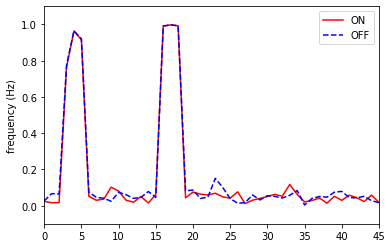

In [109]:
test_stats(1)

/Users/moritzgerster/Documents/Code/Litvak11/code/csd_helper.py:175: RuntimeWarning: divide by zero encountered in arctanh
  x_mag = np.arctanh(x_mag)
/Users/moritzgerster/Documents/Code/Litvak11/code/csd_helper.py:176: RuntimeWarning: divide by zero encountered in arctanh
  y_mag = np.arctanh(y_mag)
/Users/moritzgerster/Documents/Code/Litvak11/code/csd_helper.py:179: RuntimeWarning: invalid value encountered in subtract
  (x_mag - x_mag_mean[...,np.newaxis])**2, -1)
/Users/moritzgerster/Documents/Code/Litvak11/code/csd_helper.py:182: RuntimeWarning: invalid value encountered in subtract
  (y_mag - y_mag_mean[...,np.newaxis])**2, -1)
/Users/moritzgerster/Documents/Code/Litvak11/code/csd_helper.py:184: RuntimeWarning: invalid value encountered in subtract
  t_mag = ((x_mag_mean - y_mag_mean) /
/Users/moritzgerster/Documents/Code/Litvak11/code/csd_helper.py:200: RuntimeWarning: invalid value encountered in true_divide
  t_imag = ((x_imag_mean - y_imag_mean) /
100%|██████████| 221/221 [00

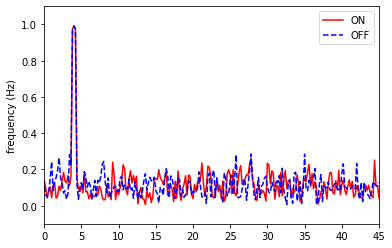

In [52]:
test_stats(1.05)

/Users/moritzgerster/Documents/Code/Litvak11/code/csd_helper.py:175: RuntimeWarning: divide by zero encountered in arctanh
  x_mag = np.arctanh(x_mag)
/Users/moritzgerster/Documents/Code/Litvak11/code/csd_helper.py:176: RuntimeWarning: divide by zero encountered in arctanh
  y_mag = np.arctanh(y_mag)
/Users/moritzgerster/Documents/Code/Litvak11/code/csd_helper.py:179: RuntimeWarning: invalid value encountered in subtract
  (x_mag - x_mag_mean[...,np.newaxis])**2, -1)
/Users/moritzgerster/Documents/Code/Litvak11/code/csd_helper.py:182: RuntimeWarning: invalid value encountered in subtract
  (y_mag - y_mag_mean[...,np.newaxis])**2, -1)
/Users/moritzgerster/Documents/Code/Litvak11/code/csd_helper.py:184: RuntimeWarning: invalid value encountered in subtract
  t_mag = ((x_mag_mean - y_mag_mean) /
/Users/moritzgerster/Documents/Code/Litvak11/code/csd_helper.py:200: RuntimeWarning: invalid value encountered in true_divide
  t_imag = ((x_imag_mean - y_imag_mean) /
100%|██████████| 45/45 [00:0

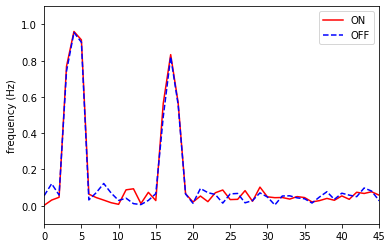

In [130]:
test_stats(1.1)

/Users/moritzgerster/Documents/Code/Litvak11/code/csd_helper.py:175: RuntimeWarning: divide by zero encountered in arctanh
  x_mag = np.arctanh(x_mag)
/Users/moritzgerster/Documents/Code/Litvak11/code/csd_helper.py:176: RuntimeWarning: divide by zero encountered in arctanh
  y_mag = np.arctanh(y_mag)
/Users/moritzgerster/Documents/Code/Litvak11/code/csd_helper.py:179: RuntimeWarning: invalid value encountered in subtract
  (x_mag - x_mag_mean[...,np.newaxis])**2, -1)
/Users/moritzgerster/Documents/Code/Litvak11/code/csd_helper.py:182: RuntimeWarning: invalid value encountered in subtract
  (y_mag - y_mag_mean[...,np.newaxis])**2, -1)
/Users/moritzgerster/Documents/Code/Litvak11/code/csd_helper.py:184: RuntimeWarning: invalid value encountered in subtract
  t_mag = ((x_mag_mean - y_mag_mean) /
/Users/moritzgerster/Documents/Code/Litvak11/code/csd_helper.py:200: RuntimeWarning: invalid value encountered in true_divide
  t_imag = ((x_imag_mean - y_imag_mean) /
100%|██████████| 5/5 [00:00<

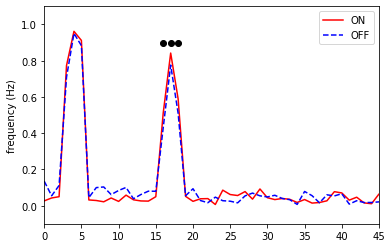

In [134]:
test_stats(1.2)

/Users/moritzgerster/Documents/Code/Litvak11/code/csd_helper.py:175: RuntimeWarning: divide by zero encountered in arctanh
  x_mag = np.arctanh(x_mag)
/Users/moritzgerster/Documents/Code/Litvak11/code/csd_helper.py:176: RuntimeWarning: divide by zero encountered in arctanh
  y_mag = np.arctanh(y_mag)
/Users/moritzgerster/Documents/Code/Litvak11/code/csd_helper.py:179: RuntimeWarning: invalid value encountered in subtract
  (x_mag - x_mag_mean[...,np.newaxis])**2, -1)
/Users/moritzgerster/Documents/Code/Litvak11/code/csd_helper.py:182: RuntimeWarning: invalid value encountered in subtract
  (y_mag - y_mag_mean[...,np.newaxis])**2, -1)
/Users/moritzgerster/Documents/Code/Litvak11/code/csd_helper.py:184: RuntimeWarning: invalid value encountered in subtract
  t_mag = ((x_mag_mean - y_mag_mean) /
/Users/moritzgerster/Documents/Code/Litvak11/code/csd_helper.py:200: RuntimeWarning: invalid value encountered in true_divide
  t_imag = ((x_imag_mean - y_imag_mean) /
100%|██████████| 45/45 [00:0

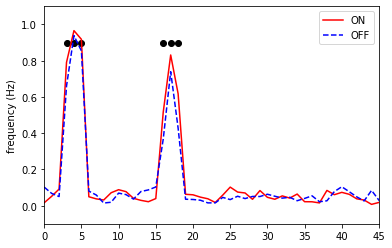

In [132]:
test_stats(1.3)